## Линейные модели или решающие деревья?

Раньше мы разбирали линейные модели, которые имеют совсем другую природу по отношению к решающим деревьям. Можно ли сказать, что какой-то из этих двух типов моделей всегда лучше? Нет. В зависимости от пространственной структуры данных, один из них будет работать лучше:

- Линейная модель, если данные хорошо линейно разделимы

- Решающие деревья, если данные плохо линейно разделимы (присутствуют только кусочно-линейные или нелинейные зависимости)

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


%matplotlib inline
plt.rcParams["figure.figsize"] = (11, 6.5)

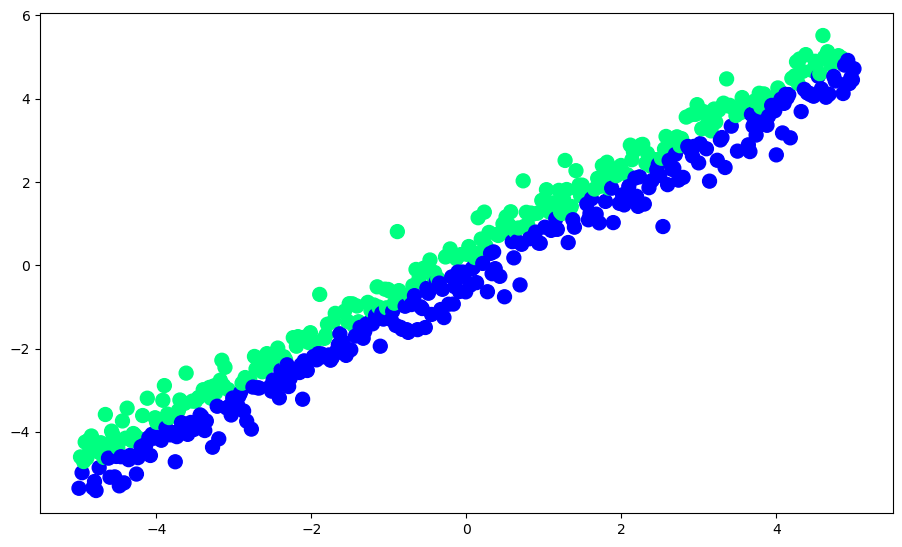

In [2]:
np.random.seed(13)
n = 500
X = np.zeros(shape=(n, 2))
X[:, 0] = np.linspace(-5, 5, 500)
X[:, 1] = X[:, 0] + 0.5 * np.random.normal(size=n)
y = (X[:, 1] > X[:, 0]).astype(int)
plt.scatter(X[:, 0], X[:, 1], s=100, c=y, cmap="winter")
plt.show()

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

lr = LogisticRegression(random_state=13)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print(f"Linear model accuracy: {accuracy_score(y_pred_lr, y_test):.2f}")

Linear model accuracy: 0.99


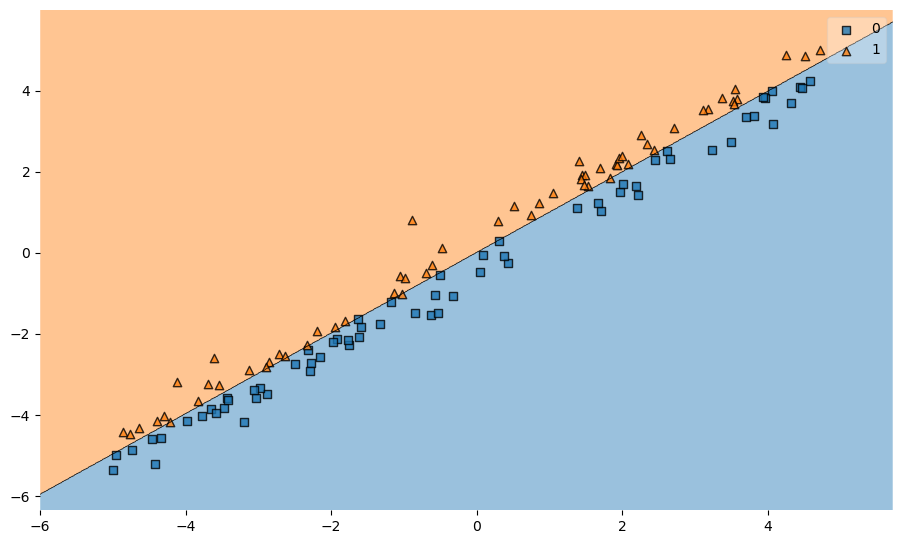

In [4]:
# !pip install mlxtend
from mlxtend.plotting import plot_decision_regions
plot_decision_regions(X_test, y_test, lr)

plt.show()

In [5]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=13)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

print(f"Decision tree accuracy: {accuracy_score(y_pred_dt, y_test):.2f}")

Decision tree accuracy: 0.86


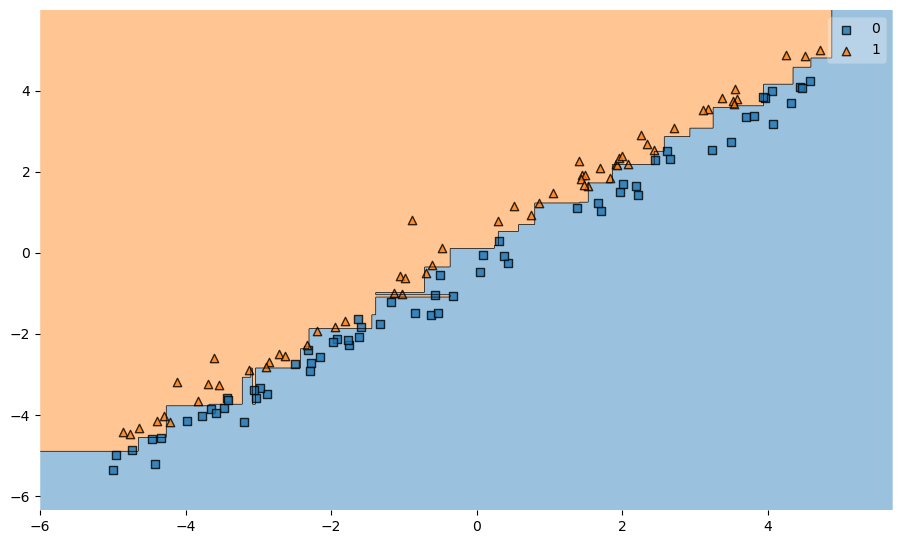

In [6]:
plot_decision_regions(X_test, y_test, dt)
plt.show()

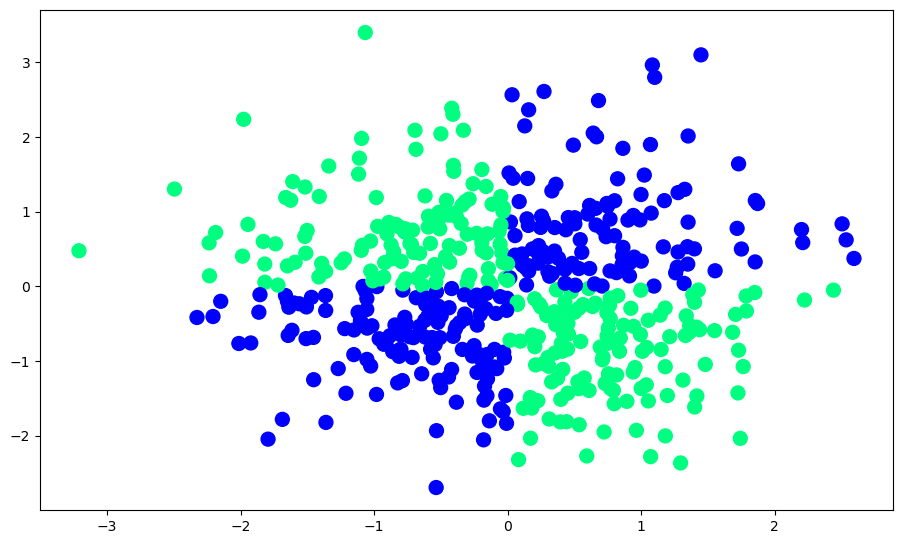

In [7]:
np.random.seed(13)
X = np.random.randn(500, 2)
y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0).astype(int)
plt.scatter(X[:, 0], X[:, 1], s=100, c=y, cmap="winter")
plt.show()

Linear model accuracy: 0.39


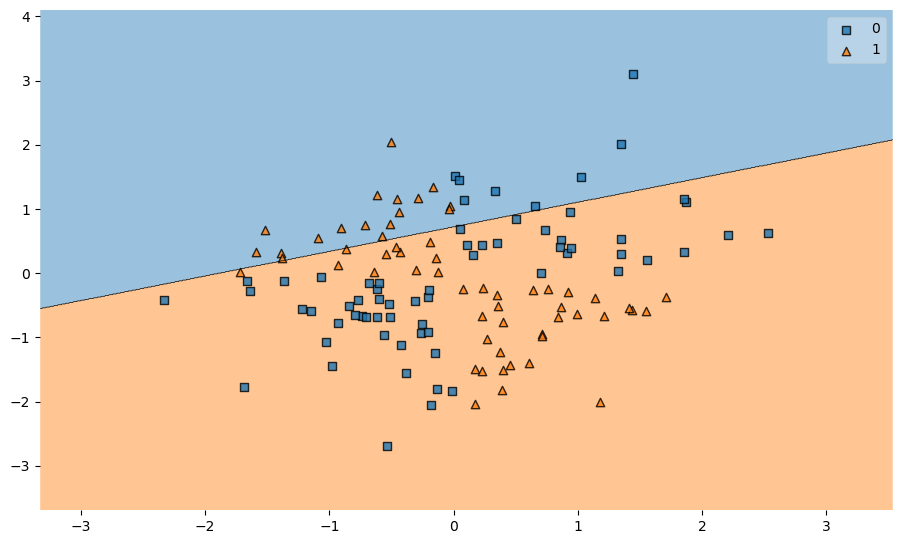

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

lr = LogisticRegression(random_state=13)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print(f"Linear model accuracy: {accuracy_score(y_pred_lr, y_test):.2f}")

plot_decision_regions(X_test, y_test, lr)
plt.show()

Linear model accuracy: 0.97


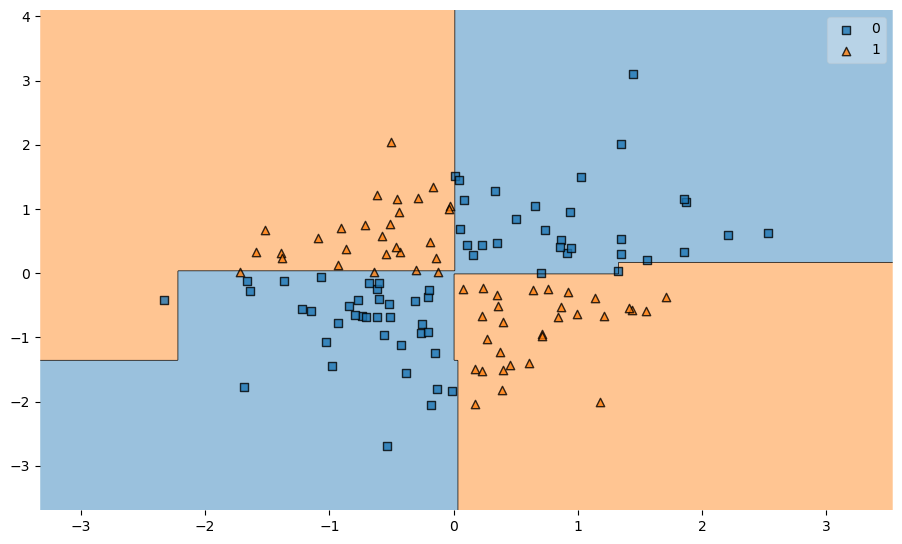

In [9]:
dt = DecisionTreeClassifier(random_state=13)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

print(f"Linear model accuracy: {accuracy_score(y_pred_dt, y_test):.2f}")

plot_decision_regions(X_test, y_test, dt)
plt.show()

## Переобучение

Решающие деревья способны переобучиться под любую выборку, если их никак не регуляризовать: при большом количестве листьев для каждого объекта может выделиться своя область в признаковом пространстве. По сути дерево просто выучивает обучающую выборку, но выделяет никаких закономерностей среди данных. Давайте убедимся в этом эффекте на практике, сгенерировав два трудноразделимых множества объектов.

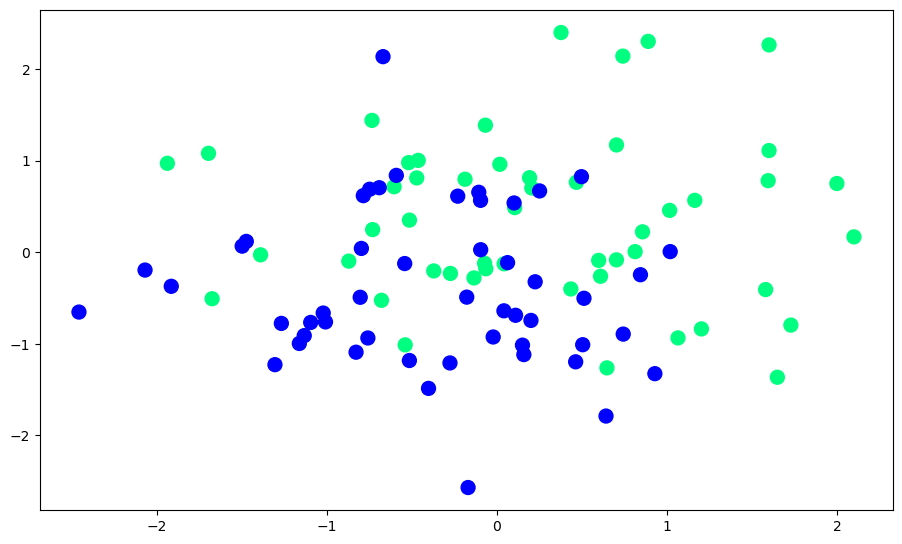

In [10]:
np.random.seed(13)
n = 100
X = np.random.normal(size=(n, 2))
X[:50, :] += 0.25
X[50:, :] -= 0.25
y = np.array([1] * 50 + [0] * 50)
plt.scatter(X[:, 0], X[:, 1], s=100, c=y, cmap="winter")
plt.show()

Посмотрим, как влияют разные значения гиперпараметров решающего дерева на его структуру:

- `max_depth`: максимальная глубина дерева
- `min_samples_leaf`: минимальное число объектов в вершине дерева, необходимое для того, чтобы она стала листовой

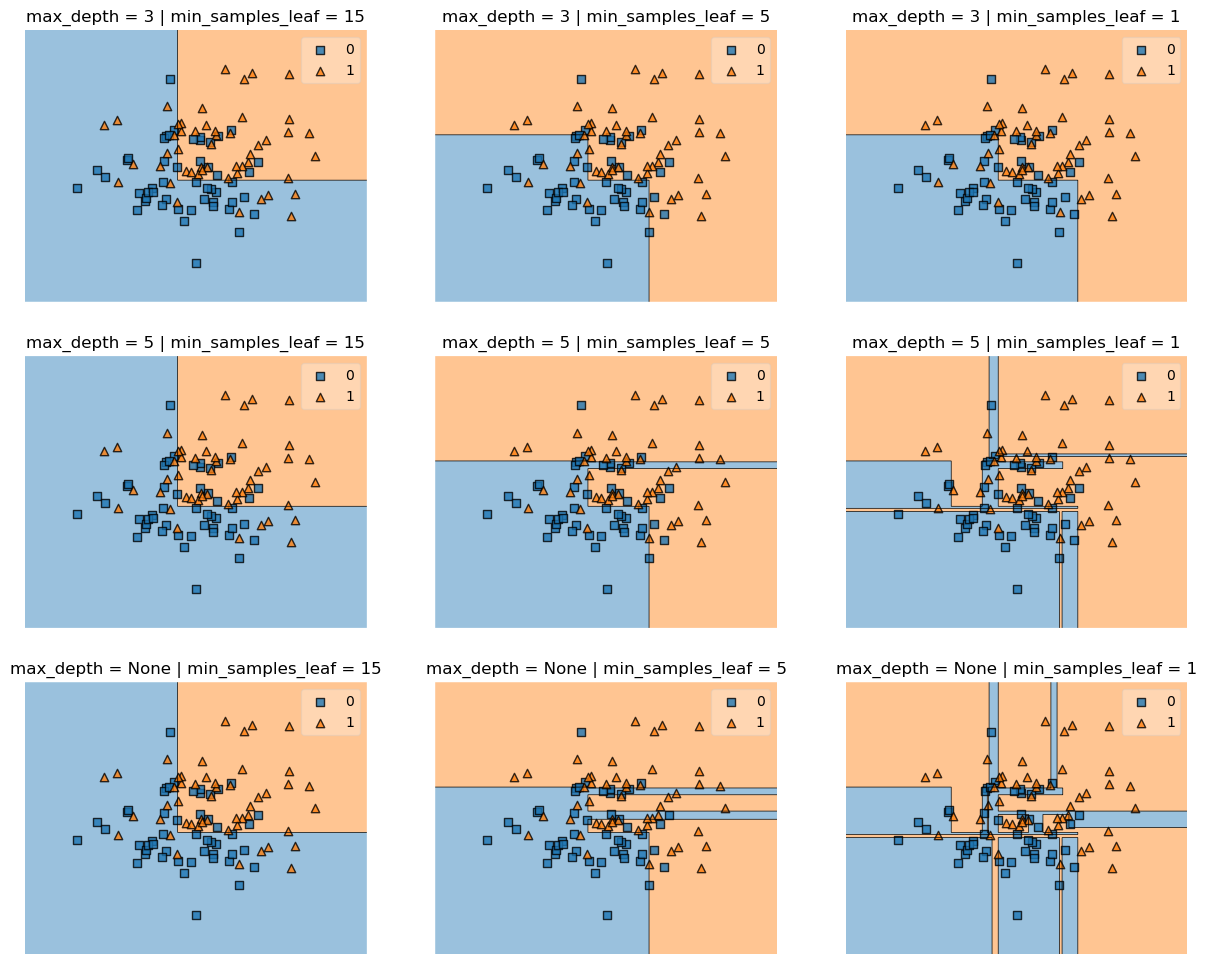

In [11]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))

for i, max_depth in enumerate([3, 5, None]):
    for j, min_samples_leaf in enumerate([15, 5, 1]):
        dt = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=13)
        dt.fit(X, y)
        ax[i][j].set_title("max_depth = {} | min_samples_leaf = {}".format(max_depth, min_samples_leaf))
        ax[i][j].axis("off")
        plot_decision_regions(X, y, dt, ax=ax[i][j])
        
plt.show()

На любой выборке (исключая те, где есть объекты с одинаковыми значениями признаков, но разными ответами) можно получить нулевую ошибку - с помощью максимально переобученного дерева:

Decision tree accuracy: 1.00


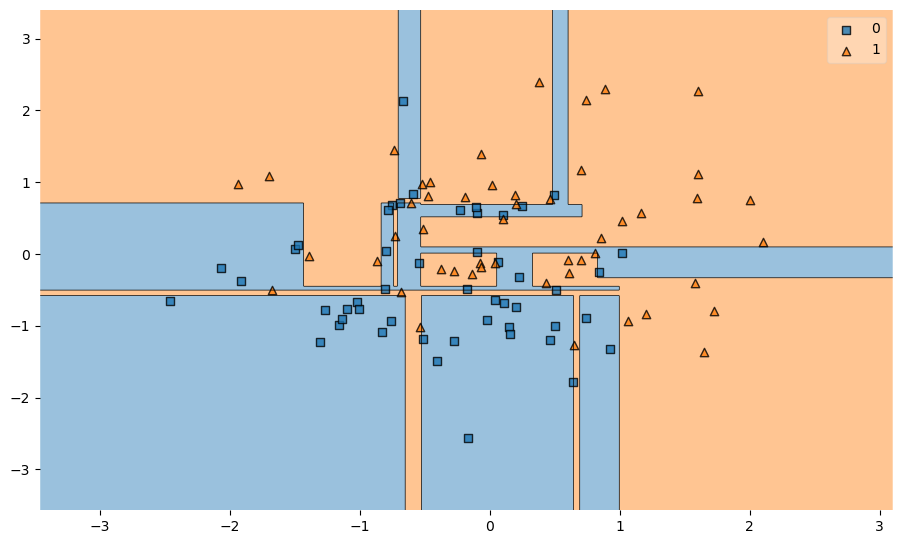

In [12]:
dt = DecisionTreeClassifier(max_depth=None, min_samples_leaf=1, random_state=13)
dt.fit(X, y)

print(f"Decision tree accuracy: {accuracy_score(y, dt.predict(X)):.2f}")

plot_decision_regions(X, y, dt)
plt.show()

## Неустойчивость

Посмотрим, как будет меняться структура дерева, если брать для обучения разные 90%-ые подвыборки исходной выборки.

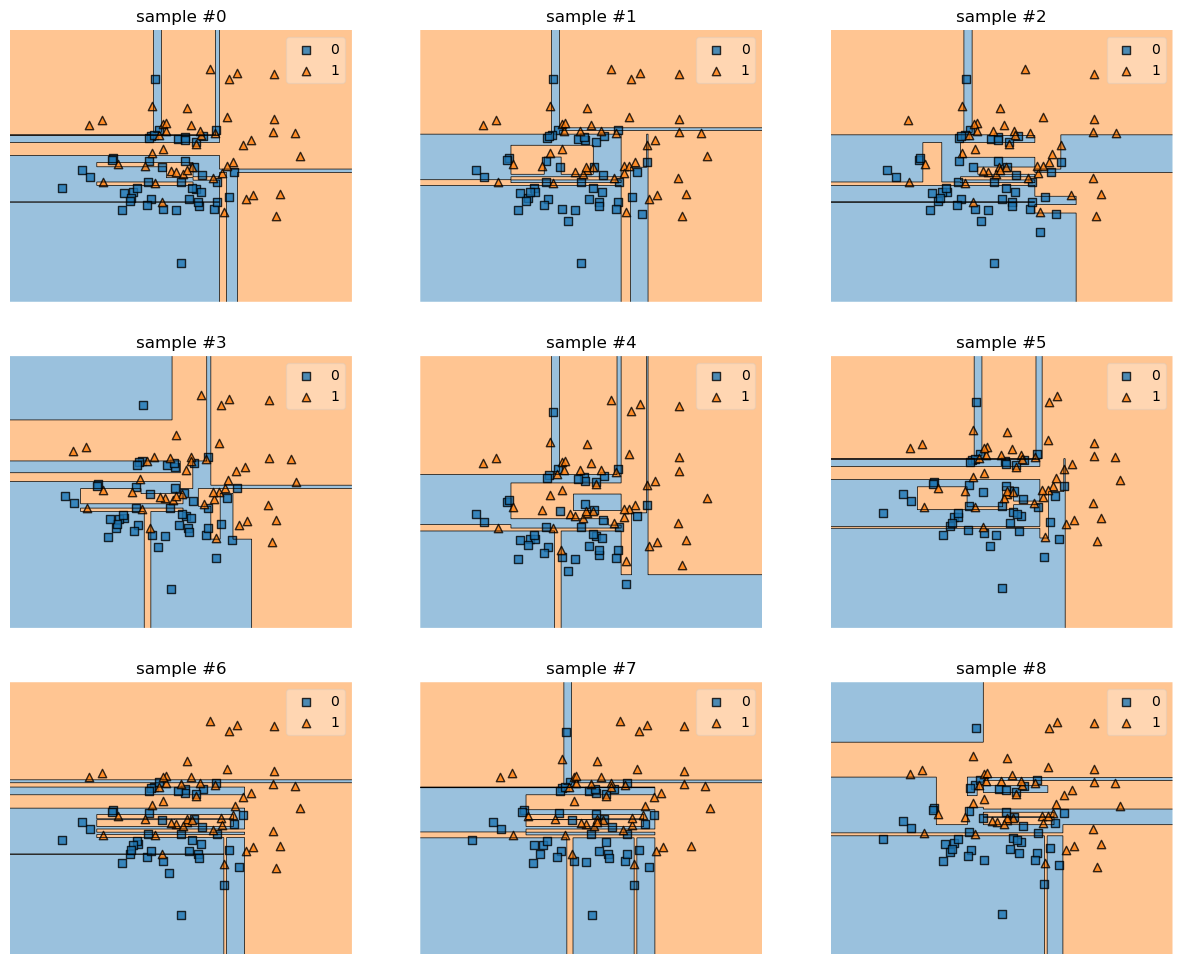

In [13]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))

for i in range(3):
    for j in range(3):
        seed_idx = 3 * i + j
        np.random.seed(seed_idx)
        dt = DecisionTreeClassifier(random_state=13)
        idx_part = np.random.choice(len(X), replace=False, size=int(0.9 * len(X)))
        X_part, y_part = X[idx_part, :], y[idx_part]
        dt.fit(X_part, y_part)
        ax[i][j].set_title("sample #{}".format(seed_idx))
        ax[i][j].axis("off")
        plot_decision_regions(X_part, y_part, dt, ax=ax[i][j])
        
plt.show()

### Практика

In [14]:
import pandas as pd
import warnings
from sklearn.datasets import load_boston

In [15]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    boston = load_boston()
X = pd.DataFrame(data=boston["data"], columns=boston["feature_names"])
y = boston["target"]

print(f"Data shape: {X.shape}")
X.head()

Data shape: (506, 13)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

In [17]:
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor, plot_tree

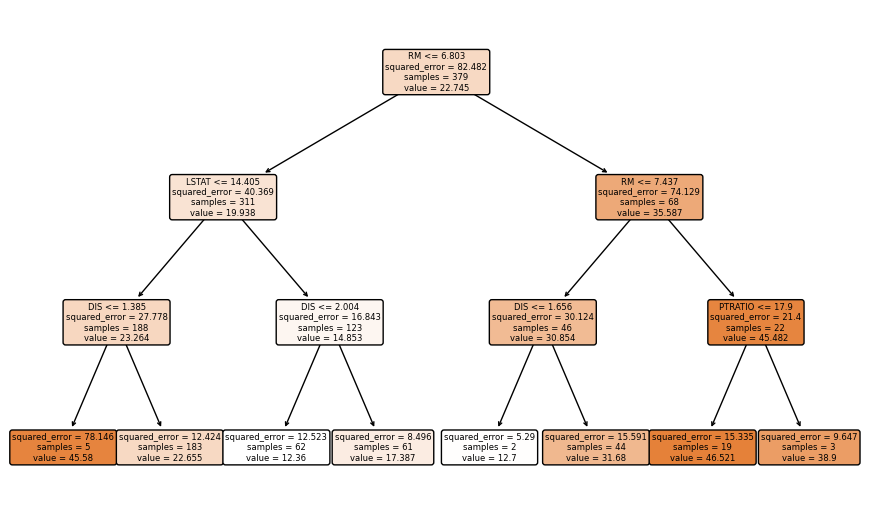

In [18]:
dt = DecisionTreeRegressor(max_depth=3, random_state=13)
dt.fit(X_train, y_train)

plot_tree(dt, feature_names=X.columns, filled=True, rounded=True)
plt.show()

In [19]:
mean_squared_error(y_test, dt.predict(X_test))

37.7071346843913

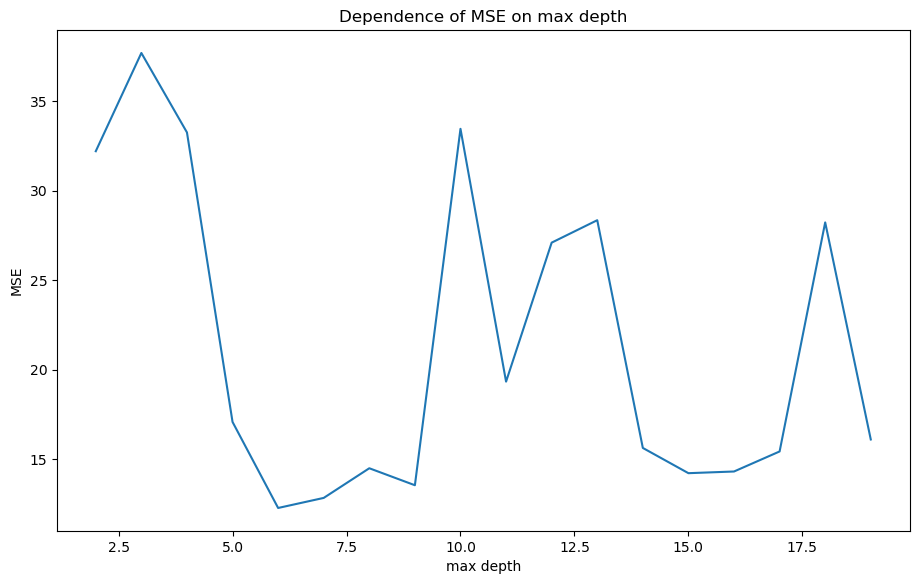

In [20]:
max_depth_array = range(2, 20)
mse_array = []

for max_depth in max_depth_array:
    dt = DecisionTreeRegressor(max_depth=max_depth, random_state=13)
    dt.fit(X_train, y_train)
    mse_array.append(mean_squared_error(y_test, dt.predict(X_test)))

plt.plot(max_depth_array, mse_array)
plt.title("Dependence of MSE on max depth")
plt.xlabel("max depth")
plt.ylabel("MSE")
plt.show()

In [21]:
pd.DataFrame({
    "max_depth": max_depth_array,
    "MSE": mse_array
}).sort_values(by="MSE").reset_index(drop=True)

,max_depth,MSE
0,6,12.259769
1,7,12.822513
2,9,13.531328
3,15,14.205564
4,16,14.299599
5,8,14.481238
6,17,15.420090
7,14,15.616905
8,19,16.090492
9,5,17.071137


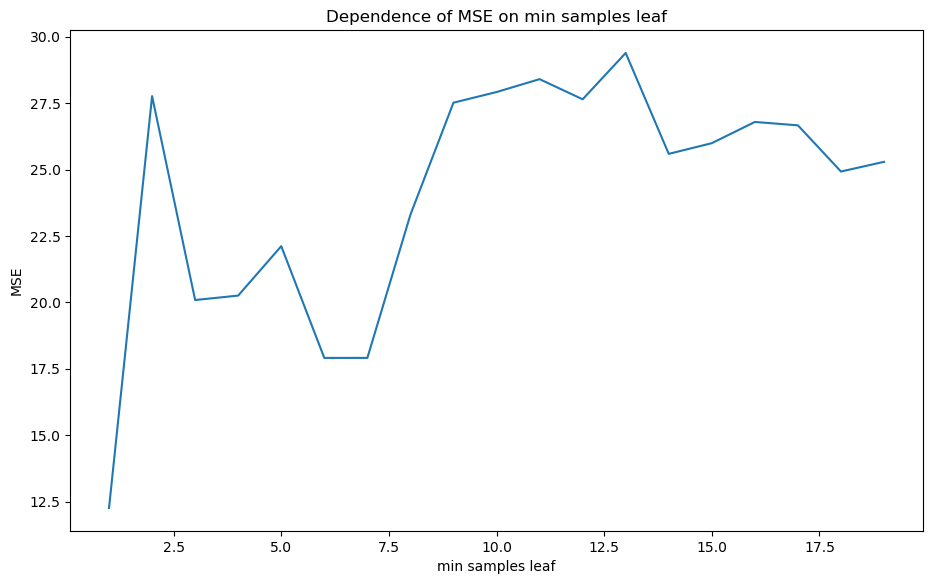

In [22]:
min_samples_leaf_array = range(1, 20)
mse_array = []

for min_samples_leaf in min_samples_leaf_array:
    dt = DecisionTreeRegressor(max_depth=6, min_samples_leaf=min_samples_leaf, random_state=13)
    dt.fit(X_train, y_train)
    mse_array.append(mean_squared_error(y_test, dt.predict(X_test)))
    
plt.plot(min_samples_leaf_array, mse_array)
plt.title("Dependence of MSE on min samples leaf")
plt.xlabel("min samples leaf")
plt.ylabel("MSE")
plt.show()

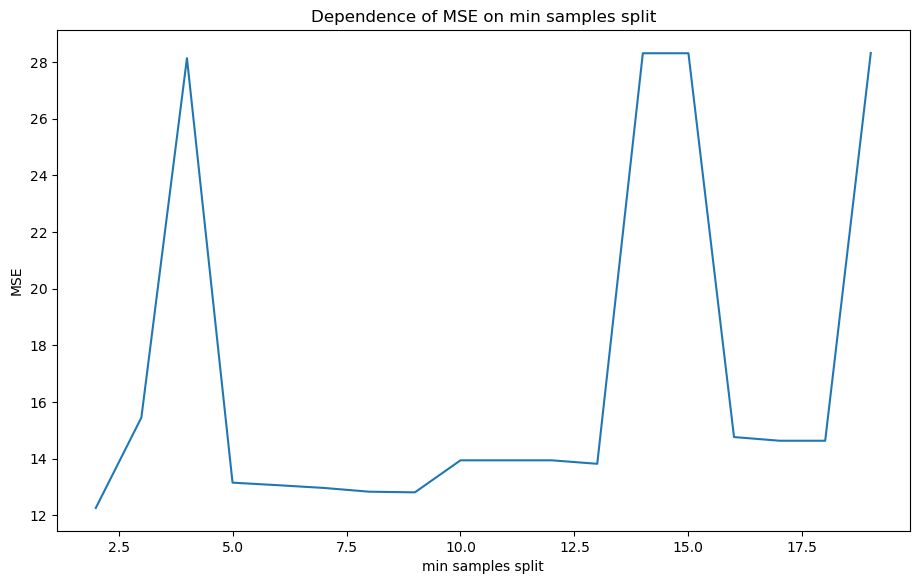

In [23]:
min_samples_split_array = range(2, 20)
mse_array = []

for min_samples_split in min_samples_split_array:
    dt = DecisionTreeRegressor(max_depth=6, min_samples_split=min_samples_split, random_state=13)
    dt.fit(X_train, y_train)
    mse_array.append(mean_squared_error(y_test, dt.predict(X_test)))

plt.plot(min_samples_split_array, mse_array)
plt.title("Dependence of MSE on min samples split")
plt.xlabel("min samples split")
plt.ylabel("MSE")
plt.show()

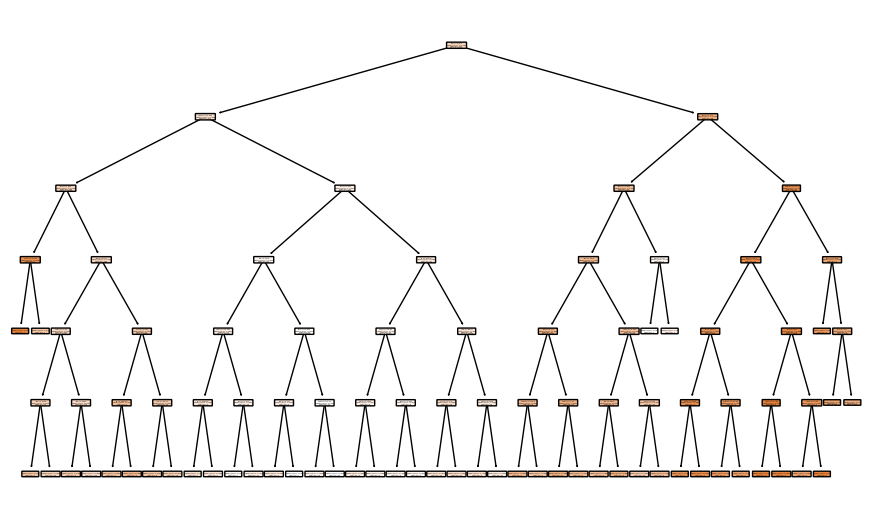

In [24]:
dt = DecisionTreeRegressor(max_depth=6, random_state=13)
dt.fit(X_train, y_train)
plot_tree(dt, feature_names=X.columns, filled=True, rounded=True)
plt.show()

In [25]:
mean_squared_error(y_test, dt.predict(X_test))

12.259769039156408

In [26]:
dt.feature_importances_

array([0.0017915 , 0.        , 0.00353474, 0.        , 0.02687167,
       0.59766384, 0.00478304, 0.11292126, 0.0035135 , 0.02381713,
       0.0062183 , 0.00726   , 0.21162502])

In [27]:
pd.DataFrame({
    "feature": X.columns,
    "importance": dt.feature_importances_
}).sort_values(by="importance", ascending=False).reset_index(drop=True)

,feature,importance
0,RM,0.597664
1,LSTAT,0.211625
2,DIS,0.112921
3,NOX,0.026872
4,TAX,0.023817
5,B,0.007260
6,PTRATIO,0.006218
7,AGE,0.004783
8,INDUS,0.003535
9,RAD,0.003514


Влияет ли масштабирование признаков на решающее дерево?

In [28]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_scaled = pd.DataFrame(sc.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(sc.transform(X_test), columns=X_test.columns, index=X_test.index)
X_train_scaled.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
61,-0.382049,0.606785,-0.848363,-0.260011,-0.851779,-0.488599,0.896957,1.486665,-0.159888,-0.690253,0.592093,0.185671,0.285327
97,-0.388162,-0.486443,-1.176083,-0.260011,-0.922106,2.624087,0.271248,-0.164958,-0.859089,-0.737557,-0.214771,0.404139,-1.192625
13,-0.327024,-0.486443,-0.407990,-0.260011,-0.104556,-0.513761,-0.239387,0.437534,-0.626022,-0.554256,1.209107,0.404139,-0.607512
207,-0.372405,-0.486443,-0.049546,-0.260011,-0.535308,-0.759460,0.152580,0.262298,-0.626022,-0.731644,0.070004,0.317425,0.808317
110,-0.389711,-0.486443,-0.346542,-0.260011,-0.262791,-0.149652,-0.505493,-0.521493,-0.509488,-0.098960,1.161645,0.364554,0.077287


In [29]:
print("No scaling is applied\n")

for max_depth in [3, 6]:
    dt = DecisionTreeRegressor(max_depth=max_depth, random_state=13)
    dt.fit(X_train, y_train)
    print(f"MSE on test set for depth {max_depth}: {mean_squared_error(y_test, dt.predict(X_test)):.2f}")

No scaling is applied

MSE on test set for depth 3: 37.71
MSE on test set for depth 6: 12.26


In [30]:
print("Standard scaling is applied\n")

for max_depth in [3, 6]:
    dt = DecisionTreeRegressor(max_depth=max_depth, random_state=13)
    dt.fit(X_train_scaled, y_train)
    print(f"MSE on test set for depth {max_depth}: {mean_squared_error(y_test, dt.predict(X_test_scaled)):.2f}")

Standard scaling is applied

MSE on test set for depth 3: 37.71
MSE on test set for depth 6: 12.26
